C:\Users\kayus\AppData\Local\Temp\ipykernel_10232\4063877751.py:5: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


Loading dataset...
Running sentiment predictions on dataset...

--- Prediction Results ---
   Review_ID Predicted_Sentiment  \
0       1001            Positive   
1       1002             Neutral   
2       1003            Negative   
3       1004             Neutral   
4       1005             Neutral   

                                         Review_Text  
0  Excellent sound quality and amazing noise canc...  
1    Battery drains fast and charging takes forever.  
2                Very uncomfortable and sound leaks.  
3              Accurate tracking and stylish design.  
4                         Screen freezes frequently.  

--- Running K-Means Clustering ---

Extracting top words per cluster (K=3)...
Cluster 0 mapped to -> lightweight / perfect / fit
Cluster 1 mapped to -> battery / sole / quickly
Cluster 2 mapped to -> quality / noise / sound
Reducing dimensions for scatter plot visualization...


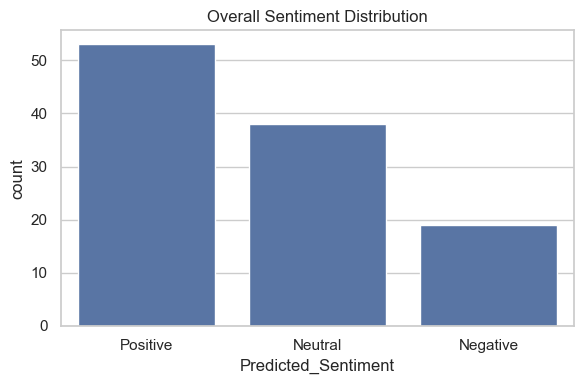

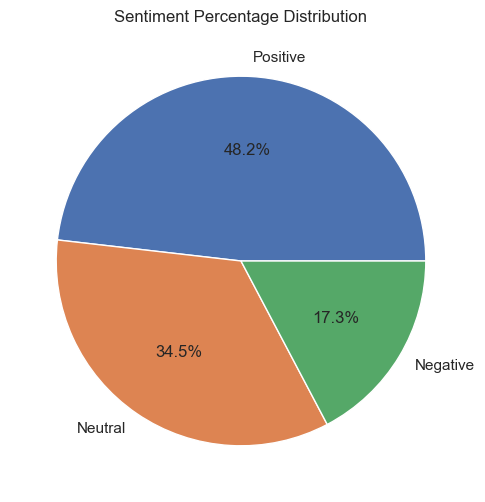

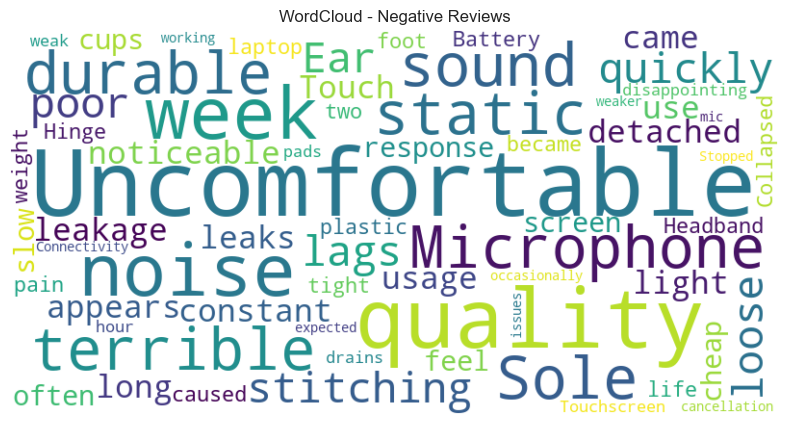

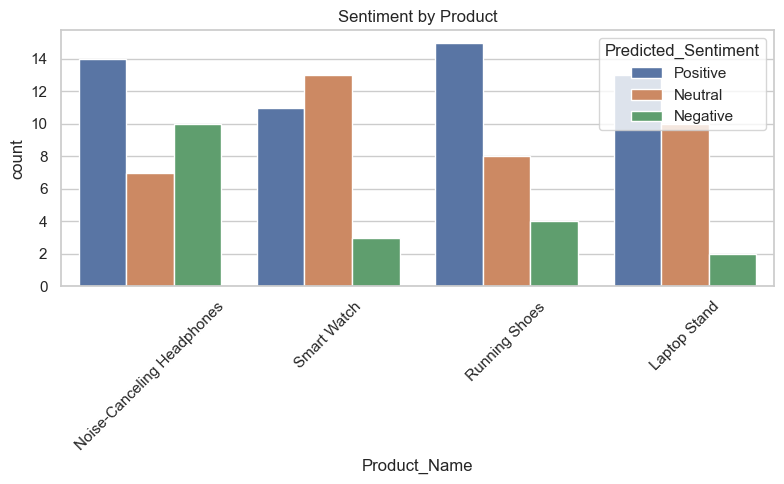

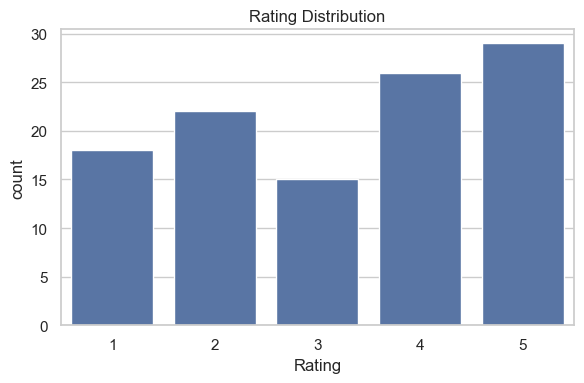

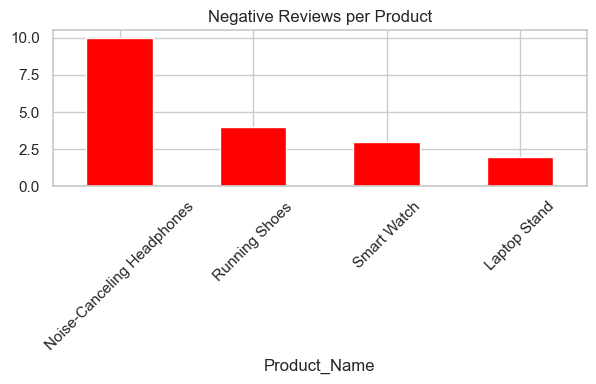

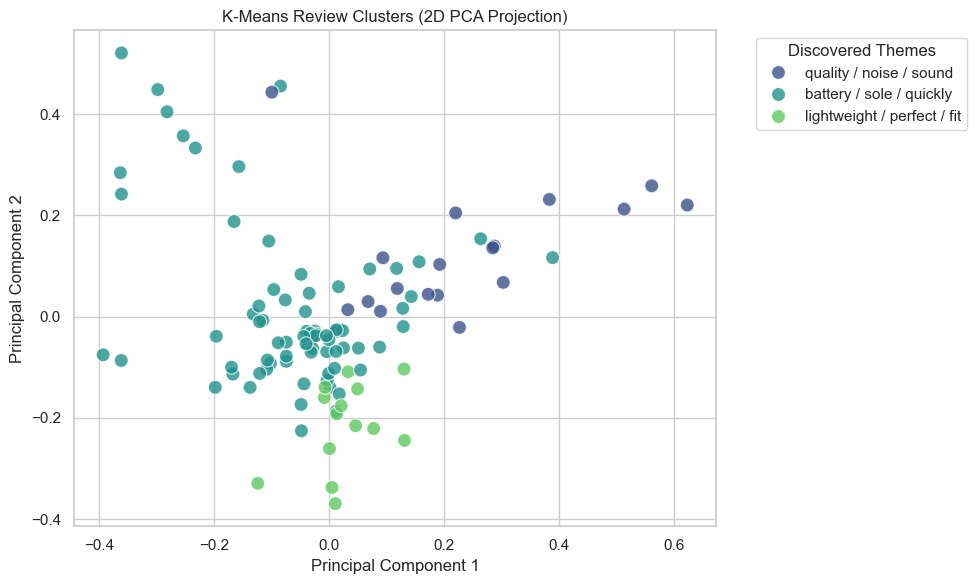


--- Generating AI Business Insights for Noise-Canceling Headphones ---
Prediction Error: 400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key not valid. Please pass a valid API key."
]


In [1]:
from wordcloud import WordCloud
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import google.generativeai as genai
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# --- NEW IMPORT FOR SCATTER PLOT ---
from sklearn.decomposition import PCA

# Download required NLTK data for sentiment scoring
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

# Configure the LLM API
genai.configure(api_key=os.environ.get("GEMINI_API_KEY", "YOUR_API_KEY_HERE"))

def predict_sentiment(text):
    """
    Analyzes raw text and predicts the sentiment polarity.
    """
    scores = sia.polarity_scores(str(text))
    compound_score = scores['compound']
   
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def generate_insights(reviews_list, product_name):
    """
    Passes grouped reviews to the Generative AI model for business insights.
    """
    if not reviews_list:
        return "No critical reviews found."

    reviews_text = "\n- ".join(reviews_list)
    prompt = f"""
    Analyze the following negative feedback for '{product_name}':
    {reviews_text}
   
    Provide a 3-bullet-point summary of the core issues and suggest 1 actionable technical fix.
    """
   
    try:
        model = genai.GenerativeModel('gemini-1.5-flash')
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Prediction Error: {e}"
   
if __name__ == "__main__":

    print("Loading dataset...")
    df = pd.read_csv('product_reviews.csv')
    df['Review_Text'] = df['Review_Text'].fillna('')

    print("Running sentiment predictions on dataset...")
    df['Predicted_Sentiment'] = df['Review_Text'].apply(predict_sentiment)

    print("\n--- Prediction Results ---")
    print(df[['Review_ID', 'Predicted_Sentiment', 'Review_Text']].head())

    # -------------------------------
    # K-MEANS CLUSTERING (TOPIC MODELING)
    # -------------------------------
    print("\n--- Running K-Means Clustering ---")
   
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(df['Review_Text'])

    num_clusters = 3
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    df['Cluster_Label'] = kmeans.fit_predict(X)

    # Automatically generate descriptive names based on top words
    print(f"\nExtracting top words per cluster (K={num_clusters})...")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
   
    cluster_names = {}

    for i in range(num_clusters):
        top_words = [terms[ind] for ind in order_centroids[i, :3]]
        theme_name = " / ".join(top_words)
        cluster_names[i] = theme_name
        print(f"Cluster {i} mapped to -> {theme_name}")

    df['Cluster_Theme'] = df['Cluster_Label'].map(cluster_names)

    # --- NEW: REDUCE DIMENSIONS FOR SCATTER PLOT ---
    print("Reducing dimensions for scatter plot visualization...")
    pca = PCA(n_components=2, random_state=42)
    # Convert sparse TF-IDF matrix to dense array for PCA
    pca_result = pca.fit_transform(X.toarray())
   
    # Add the 2D coordinates to our dataframe
    df['PCA_X'] = pca_result[:, 0]
    df['PCA_Y'] = pca_result[:, 1]

    # -------------------------------
    # GRAPHICAL ANALYSIS
    # -------------------------------
    sns.set_theme(style="whitegrid")

    # 1️⃣ Sentiment Distribution
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='Predicted_Sentiment')
    plt.title("Overall Sentiment Distribution")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,6))
    sentiment_counts = df['Predicted_Sentiment'].value_counts()
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
    plt.title("Sentiment Percentage Distribution")
    plt.show()

    negative_text = " ".join(df[df['Predicted_Sentiment'] == 'Negative']['Review_Text'])

    if negative_text.strip() != "":
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
       
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("WordCloud - Negative Reviews")
        plt.show()

    # 2️⃣ Product-wise Sentiment
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x='Product_Name', hue='Predicted_Sentiment')
    plt.xticks(rotation=45)
    plt.title("Sentiment by Product")
    plt.tight_layout()
    plt.show()

    # 3️⃣ Rating Distribution
    if 'Rating' in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(data=df, x='Rating')
        plt.title("Rating Distribution")
        plt.tight_layout()
        plt.show()

    # 4️⃣ Negative Reviews per Product
    negative_counts = df[df['Predicted_Sentiment'] == 'Negative']['Product_Name'].value_counts()

    if not negative_counts.empty:
        plt.figure(figsize=(6,4))
        negative_counts.plot(kind='bar', color='red')
        plt.title("Negative Reviews per Product")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 5️⃣ Cluster Scatter Plot (REPLACED BAR CHART)
    plt.figure(figsize=(10, 6))
   
    sns.scatterplot(
        data=df,
        x='PCA_X',
        y='PCA_Y',
        hue='Cluster_Theme',
        palette='viridis',
        s=100, # Size of the dots
        alpha=0.8 # Slight transparency to see overlapping points
    )
   
    plt.title("K-Means Review Clusters (2D PCA Projection)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
   
    # Move the legend outside the plot so it doesn't cover data points
    plt.legend(title="Discovered Themes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # AI INSIGHT GENERATION
    # -------------------------------
    target_product = "Noise-Canceling Headphones"

    negative_reviews = df[
        (df['Product_Name'] == target_product) &
        (df['Predicted_Sentiment'] == 'Negative')
    ]['Review_Text'].tolist()

    print(f"\n--- Generating AI Business Insights for {target_product} ---")
    insights = generate_insights(negative_reviews, target_product)
    print(insights)